In [215]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon


# Loading Raw Data

In [216]:
ia_Q_path = "full/ia_Q.csv"
ia_A_path = "full/ia_A.csv"
ia_QA_path = "full/ia_QA.csv"

In [217]:
#df_Q = pd.read_csv(ia_Q_path)
df_A = pd.read_csv(ia_A_path)
#df_QA = pd.read_csv(ia_QA_path)

# Selecting Relevant and Separating Reading Regimes

In [218]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True]
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False]

# Generating Basic By Row Features

In [219]:
def create_area_label(df):
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['a_tokens'] = df['answer_1'].str.split()
    df['b_tokens'] = df['answer_2'].str.split()
    df['c_tokens'] = df['answer_3'].str.split()
    df['d_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['a_len'] = df['a_tokens'].apply(len)
    df['b_len'] = df['b_tokens'].apply(len)
    df['c_len'] = df['c_tokens'].apply(len)
    df['d_len'] = df['d_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        a_len = group['a_len'].iloc[0]
        b_len = group['b_len'].iloc[0]
        c_len = group['c_len'].iloc[0]
        d_len = group['d_len'].iloc[0]

        q_end = q_len - 1
        a_end = q_len + a_len - 1
        b_end = q_len + a_len + b_len - 1
        c_end = q_len + a_len + b_len + c_len - 1

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= a_end),
            (index_id > a_end) & (index_id <= b_end),
            (index_id > b_end) & (index_id <= c_end),
            (index_id > c_end)
        ]

        choices = ['question', 'answer_A', 'answer_B', 'answer_C', 'answer_D']
        group['area_label'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [220]:
def create_correct_answer(df):
    df = df.copy()
    df['is_correct'] = (df['selected_answer_position'] == df['correct_answer_position']).astype(int)
    return df

In [221]:
def create_area_screen_loc(df):
    def get_screen_loc(row):
        if row['area_label'] == 'question':
            return -1
        elif row['area_label'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            answer_letter = row['area_label'][-1]
            return answers_order.index(answer_letter)
        return None

    df['area_screen_loc'] = df.apply(get_screen_loc, axis=1)
    return df

In [222]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [223]:
def created_selected_area_bool(df):
    area_mapping = {
    'A': 'answer_A',
    'B': 'answer_B',
    'C': 'answer_C',
    'D': 'answer_D'
    }

    df['selected_area'] = df['selected_answer_label'].map(area_mapping)
    df['is_selected_area'] = df['area_label'] == df['selected_area']
    return df

In [ ]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_correct_answer,
    create_area_label,
    create_area_screen_loc,
    create_selected_answer_label,
    created_selected_area_bool,
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_correct_answer at 0x0000022D9C5D7520>
<function create_area_label at 0x0000022FBAFF3520>


# Specialised Groupings Features Generators

In [11]:
def create_mean_area_dwell_time(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [12]:
def create_mean_area_fix_count(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_fixations_count=("IA_FIXATION_COUNT", "mean"))

In [13]:
def create_mean_first_fix_duration(df):
    df['IA_FIRST_FIXATION_DURATION_INT'] = df["IA_FIRST_FIXATION_DURATION"].replace('.', 0).astype(int)
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(mean_first_fixation_duration=("IA_FIRST_FIXATION_DURATION_INT", "mean"))

In [14]:
def create_skip_rate(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id','area_label'], as_index=False).agg(skip_rate=("IA_SKIP", "mean"))

In [15]:
def create_dwell_proportions(df):
    aggregated_df = (
        df.groupby(['participant_id', 'TRIAL_INDEX', 'area_label'], as_index=False)
        .agg({'IA_DWELL_TIME': 'sum'})
        .rename(columns={'IA_DWELL_TIME': 'total_area_dwell_time'})
    )

    aggregated_df['total_dwell_time'] = aggregated_df.groupby(['participant_id', 'TRIAL_INDEX'])['total_area_dwell_time'].transform('sum')

    aggregated_df['area_dwell_proportion'] = aggregated_df['total_area_dwell_time'] / aggregated_df['total_dwell_time']
    aggregated_df = aggregated_df.fillna(0)

    return aggregated_df

In [16]:
def create_last_area_and_location_visited(df):
    df['IA_LAST_FIXATION_TIME_INT'] = df["IA_LAST_FIXATION_TIME"].replace('.', 0).astype(int)
    df_sorted = df.sort_values(by=['participant_id', 'TRIAL_INDEX', 'IA_LAST_FIXATION_TIME_INT'], ascending=[True, True, False])
    top_fixations = df_sorted.groupby(['participant_id', 'TRIAL_INDEX']).head(5)

    last_area = (
        top_fixations.groupby(['participant_id', 'TRIAL_INDEX'])['area_label']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'area_label': 'last_area_visited'})
    )

    last_location = (
        top_fixations.groupby(['participant_id', 'TRIAL_INDEX'])['area_screen_loc']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'area_screen_loc': 'last_location_visited'})
    )

    result = pd.merge(last_area, last_location, on=['participant_id', 'TRIAL_INDEX'])

    return result



In [17]:
def create_fixation_sequence_tags(df):
    ia_id_to_label = dict(zip(df['IA_ID'], df['area_label']))
    ia_id_to_location = dict(zip(df['IA_ID'], df['area_screen_loc']))

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)
        label_sequence = [ia_id_to_label.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        location_sequence = [ia_id_to_location.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': label_sequence,
            'fix_by_loc': location_sequence
        })

    return pd.DataFrame(result)



# Feature Generation

In [18]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [19]:
per_row_feature_generators = [
    (create_mean_area_dwell_time, {}),
    (create_mean_area_fix_count, {}),
    (create_mean_first_fix_duration, {}),
    (create_skip_rate, {}),
    (create_dwell_proportions, {}),
    (create_last_area_and_location_visited, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']})
]

In [20]:
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_mean_area_dwell_time at 0x0000022D949F5000>
<function create_mean_area_fix_count at 0x0000022D949F6E60>
<function create_mean_first_fix_duration at 0x0000022D949F6B90>
<function create_skip_rate at 0x0000022D949F5750>
<function create_dwell_proportions at 0x0000022FEFD177F0>
<function create_last_area_and_location_visited at 0x0000022DFC1000D0>
<function create_fixation_sequence_tags at 0x0000022FEFD153F0>
<function create_mean_area_dwell_time at 0x0000022D949F5000>
<function create_mean_area_fix_count at 0x0000022D949F6E60>
<function create_mean_first_fix_duration at 0x0000022D949F6B90>
<function create_skip_rate at 0x0000022D949F5750>
<function create_dwell_proportions at 0x0000022FEFD177F0>
<function create_last_area_and_location_visited at 0x0000022DFC1000D0>
<function create_fixation_sequence_tags at 0x0000022FEFD153F0>


In [197]:
df_with_features_h[['TRIAL_INDEX', 'participant_id', 'IA_LABEL',
                    'area_label', 'area_screen_loc', 'selected_answer_label', 'selected_area', 'is_selected_area', 'correct_answer_position',
                    'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate', 'area_dwell_proportion', 'last_area_visited', 'last_location_visited', 'fix_by_label', 'fix_by_loc']]

,TRIAL_INDEX,participant_id,IA_LABEL,area_label,area_screen_loc,selected_answer_label,selected_area,is_selected_area,correct_answer_position,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc
0,4,l42_2070,What,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
1,4,l42_2070,is,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
2,4,l42_2070,Currie,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
3,4,l42_2070,Technologies?,question,-1,A,answer_A,False,3,41.250000,0.250000,41.250000,0.750000,0.029044,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
4,4,l42_2070,A,answer_A,3,A,answer_A,True,3,173.000000,1.000000,94.285714,0.571429,0.213167,answer_D,2,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380345,59,l10_39,the,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."
380346,59,l10_39,head,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."
380347,59,l10_39,of,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."
380348,59,l10_39,the,answer_D,0,A,answer_A,False,1,142.833333,0.666667,99.083333,0.666667,0.300333,answer_D,0,"(out_of_bounds, answer_A, answer_A, out_of_bou...","(out_of_bounds, 1, 1, out_of_bounds, 1, 3, 3, ..."


In [22]:
df_with_features_g[['TRIAL_INDEX', 'participant_id', 'IA_LABEL',
                    'area_label', 'area_screen_loc', 'selected_answer_label', 'selected_area', 'is_selected_area',
                    'mean_dwell_time', 'mean_fixations_count', 'mean_first_fixation_duration', 'skip_rate', 'area_dwell_proportion', 'last_area_visited', 'last_location_visited', 'fix_by_label', 'fix_by_loc']]

,TRIAL_INDEX,participant_id,IA_LABEL,area_label,area_screen_loc,selected_answer_label,selected_area,is_selected_area,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited,last_location_visited,fix_by_label,fix_by_loc
0,3,l59_485,What,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
1,3,l59_485,is,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
2,3,l59_485,opposite,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
3,3,l59_485,Cockrell's,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
4,3,l59_485,office?,question,-1,B,answer_B,False,1.8,0.2,1.8,0.8,0.003419,answer_C,0,"[question, out_of_bounds, question, answer_A, ...","[-1, out_of_bounds, -1, 2, -1, 2, out_of_bound..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380273,65,l2_324,leave,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."
380274,65,l2_324,risky,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."
380275,65,l2_324,work,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."
380276,65,l2_324,in,answer_D,1,A,answer_A,False,224.2,1.1,153.4,0.6,0.414801,answer_C,3,"[question, out_of_bounds, answer_A, answer_A, ...","[-1, out_of_bounds, 2, 2, 2, 0, 0, 0, 0, 3, 3,..."


# Visualisations

### Boxplots and U-Tests

In [23]:
def plot_boxplot(dataframe, x_column, y_column, hue_column, plt_title="Boxplot"):
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=dataframe,
        x=x_column,
        y=y_column,
        hue=hue_column,
        showfliers=False
    )
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(title=hue_column)
    plt.show()


In [24]:
def analyze_metric_stat(dataframe, label_column, stat_column, correct_column):
    categories = dataframe[label_column].unique()
    results = []

    for category in categories:
        category_data = dataframe[dataframe[label_column] == category]
        correct_data = category_data[category_data[correct_column] == True]
        incorrect_data = category_data[category_data[correct_column] == False]

        if len(correct_data) == 0 or len(incorrect_data) == 0:
            continue

        correct_dwell = correct_data[stat_column]
        incorrect_dwell = incorrect_data[stat_column]

        mannwhitney_result = mannwhitneyu(correct_dwell, incorrect_dwell, alternative='two-sided')

        results.append({
            label_column: category,
            'U_statistic': mannwhitney_result.statistic,
            'p_value': mannwhitney_result.pvalue,
            'median_correct': correct_dwell.median(),
            'median_incorrect': incorrect_dwell.median(),
            'mean_correct': correct_dwell.mean(),
            'mean_incorrect': incorrect_dwell.mean()
        })

    results_df = pd.DataFrame(results)
    return results_df.sort_values('p_value')



In [25]:
def metric_analysis(metric):
    print("HUNTERS BOXPLOTS:")
    plot_boxplot(df_with_features_h, 'area_label', metric, 'is_correct', plt_title=f'{metric} by label (hunters)')
    plot_boxplot(df_with_features_h, 'area_screen_loc', metric, 'is_correct', plt_title=f'{metric} by location (hunters)')

    print("GATHERERS BOXPLOTS:")
    plot_boxplot(df_with_features_g, 'area_label', metric, 'is_correct', plt_title=f'{metric} by label (gatherers)')
    plot_boxplot(df_with_features_g, 'area_screen_loc', metric, 'is_correct', plt_title=f'{metric} by location (gatherers)')

    print("HUNTERS U_TESTS:")
    print(analyze_metric_stat(df_with_features_h, 'area_label', metric, 'is_correct'))
    print(analyze_metric_stat(df_with_features_h, 'area_screen_loc', metric, 'is_correct'))

    print("GATHERERS U_TESTS:")
    print(analyze_metric_stat(df_with_features_g, 'area_label', metric, 'is_correct'))
    print(analyze_metric_stat(df_with_features_g, 'area_screen_loc', metric, 'is_correct'))


HUNTERS BOXPLOTS:


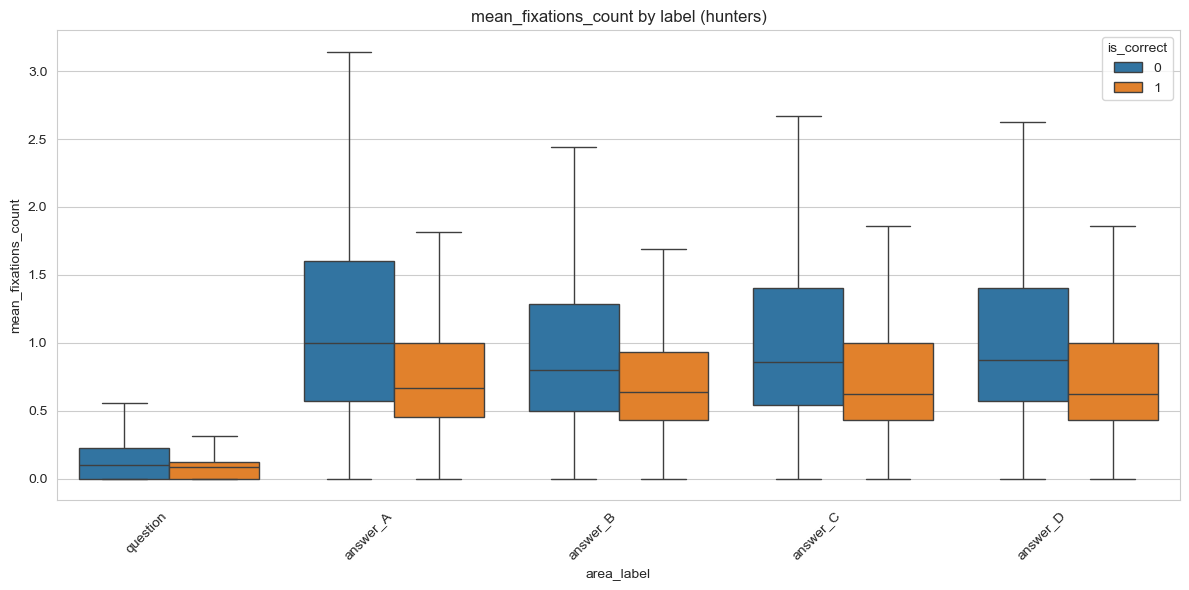

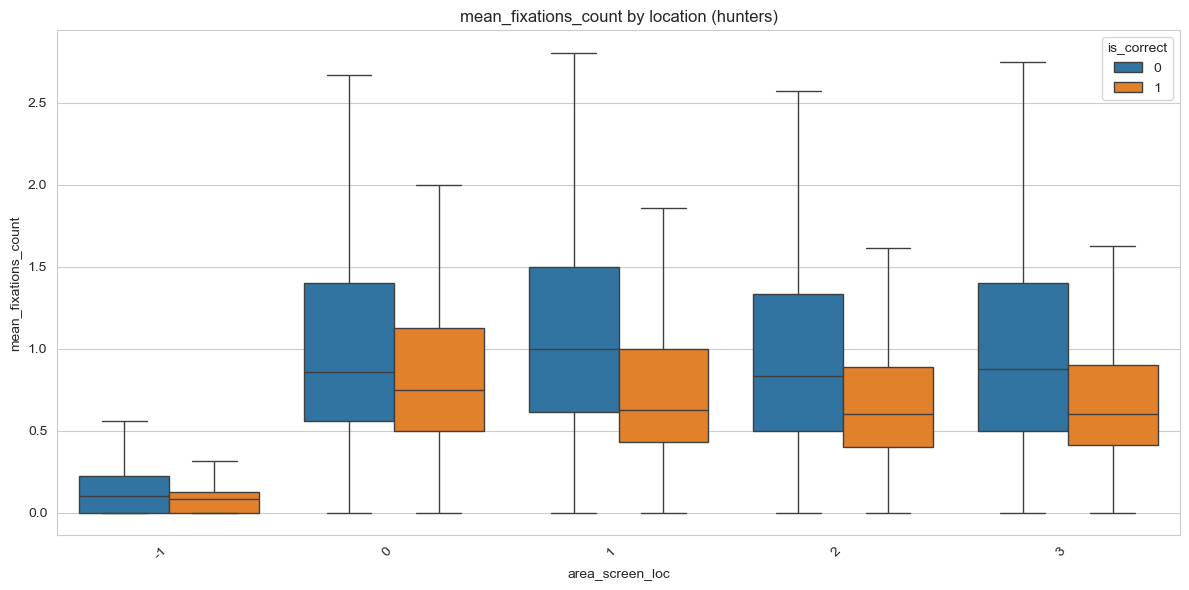

GATHERERS BOXPLOTS:


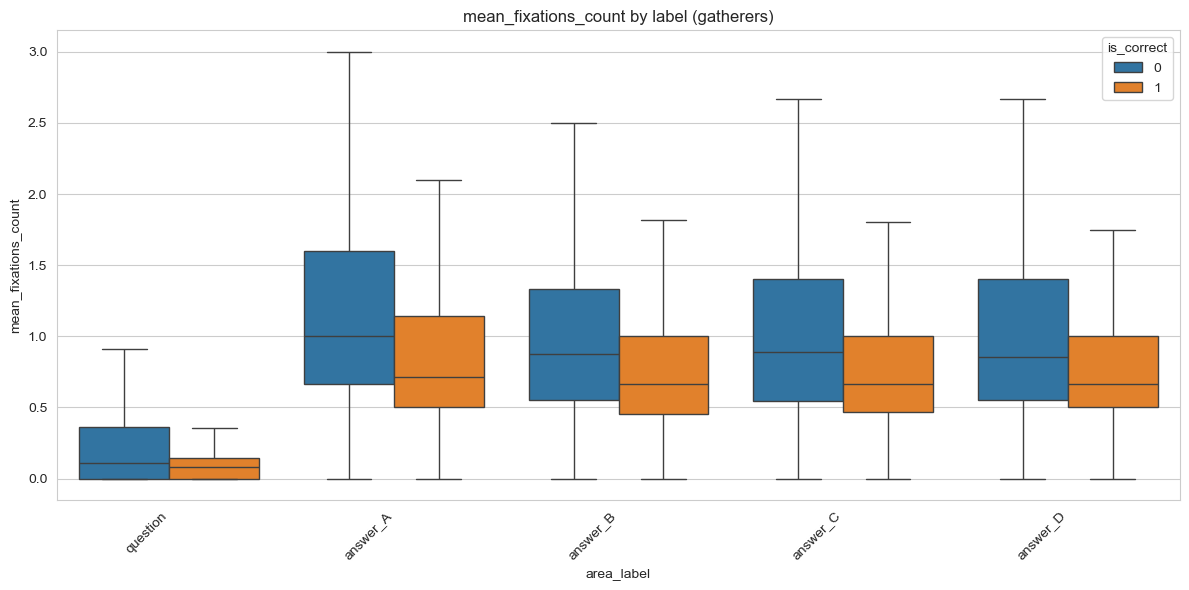

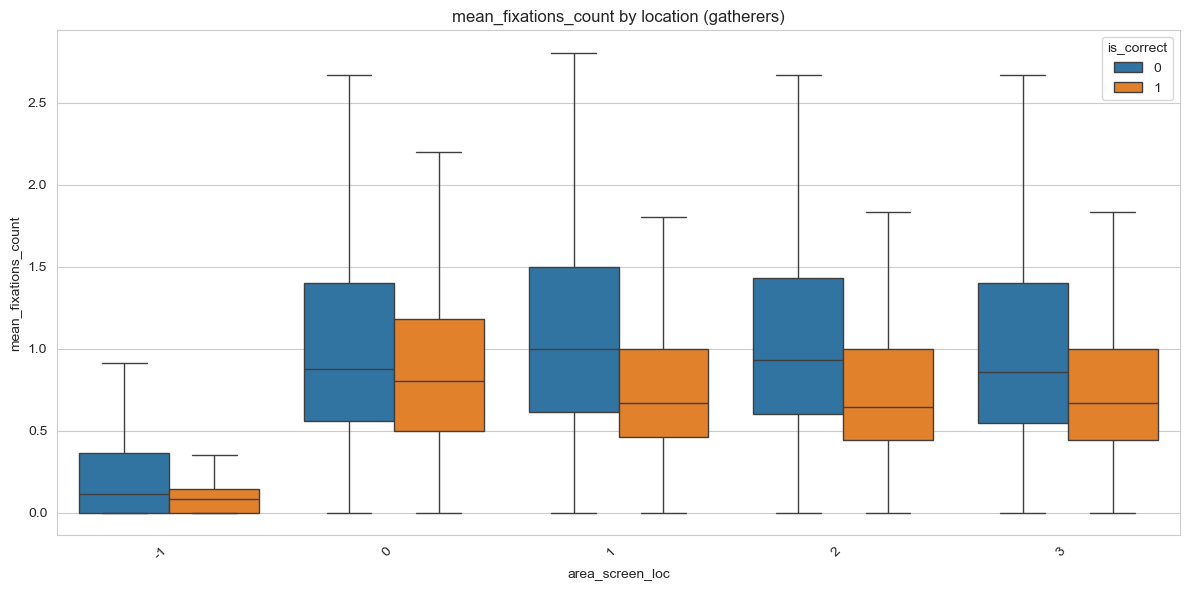

HUNTERS U_TESTS:
  area_label  U_statistic        p_value  median_correct  median_incorrect  \
1   answer_A  204982274.5   0.000000e+00        0.666667          1.000000   
3   answer_C  206625579.0   0.000000e+00        0.625000          0.857143   
4   answer_D  199803496.0   0.000000e+00        0.625000          0.875000   
2   answer_B  221123068.5  1.157951e-291        0.636364          0.800000   
0   question  442471743.5  1.512790e-158        0.083333          0.100000   

   mean_correct  mean_incorrect  
1      0.845816        1.230432  
3      0.757135        1.072789  
4      0.752971        1.119762  
2      0.748320        1.045024  
0      0.125187        0.224284  
   area_screen_loc  U_statistic        p_value  median_correct  \
1                3  192898801.5   0.000000e+00        0.600000   
3                1  184708541.5   0.000000e+00        0.625000   
4                2  217992829.0   0.000000e+00        0.600000   
0               -1  442471743.5  1.512790e-158

In [212]:
# metric_analysis('mean_dwell_time')
metric_analysis('mean_fixations_count')
# metric_analysis('mean_first_fixation_duration')
# metric_analysis('skip_rate')
# metric_analysis('area_dwell_proportion')

In [27]:
def analyze_group_differences(dataframe, label_column, stat_column, correct_column='is_correct'):
    results = []

    for is_correct_value in dataframe[correct_column].unique():
        subset_df = dataframe[dataframe[correct_column] == is_correct_value]
        categories = subset_df[label_column].unique()

        for cat1, cat2 in combinations(categories, 2):
            group1 = subset_df[subset_df[label_column] == cat1][stat_column]
            group2 = subset_df[subset_df[label_column] == cat2][stat_column]

            if len(group1) == 0 or len(group2) == 0:
                continue

            mannwhitney_result = mannwhitneyu(group1, group2, alternative='two-sided')

            results.append({
                'is_correct': is_correct_value,
                'group1': cat1,
                'group2': cat2,
                'U_statistic': mannwhitney_result.statistic,
                'p_value': mannwhitney_result.pvalue,
                'median_group1': group1.median(),
                'median_group2': group2.median(),
                'mean_group1': group1.mean(),
                'mean_group2': group2.mean()
            })

    results_df = pd.DataFrame(results)
    return results_df.sort_values(['is_correct', 'p_value'])

In [28]:
analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_dwell_time')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_dwell_time')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_fixations_count')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_fixations_count')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='mean_first_fixation_duration')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='mean_first_fixation_duration')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='skip_rate')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='skip_rate')
#
# analyze_group_differences(df_with_features_h, label_column='area_label', stat_column='area_dwell_proportion')
# analyze_group_differences(df_with_features_h, label_column='area_screen_loc', stat_column='area_dwell_proportion')

,is_correct,group1,group2,U_statistic,p_value,median_group1,median_group2,mean_group1,mean_group2
10,0,question,answer_A,9.643531e+06,0.000000e+00,14.700000,176.000000,39.902299,228.403722
11,0,question,answer_B,1.091341e+07,0.000000e+00,14.700000,150.333333,39.902299,205.601573
12,0,question,answer_C,1.038393e+07,0.000000e+00,14.700000,156.800000,39.902299,207.044111
13,0,question,answer_D,1.081960e+07,0.000000e+00,14.700000,154.777778,39.902299,211.024194
14,0,answer_A,answer_B,4.552781e+07,4.886760e-18,176.000000,150.333333,228.403722,205.601573
16,0,answer_A,answer_D,4.379070e+07,2.046652e-10,176.000000,154.777778,228.403722,211.024194
15,0,answer_A,answer_C,4.365441e+07,6.586886e-08,176.000000,156.800000,228.403722,207.044111
17,0,answer_B,answer_C,4.112315e+07,3.646945e-04,150.333333,156.800000,205.601573,207.044111
18,0,answer_B,answer_D,4.129241e+07,1.073760e-02,150.333333,154.777778,205.601573,211.024194
19,0,answer_C,answer_D,4.189698e+07,3.106783e-01,156.800000,154.777778,207.044111,211.024194


### Matrix Plots

In [29]:
def matrix_plot(df, stat, correct = 1):
    matrix = pd.pivot_table(
        data=df,
        index='area_label',
        columns='area_screen_loc',
        values=stat,
        aggfunc='mean'
    )

    ax = sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    cbar_kws={'label': f'{stat}'}
    )
    if correct == 1:
        plt.title(f"{stat} of correct answers")
    else:
        plt.title(f"{stat} of incorrect answers")
    plt.xlabel('area_screen_loc')
    plt.ylabel("area_label")
    plt.tight_layout()
    plt.show()


In [30]:
def label_vs_loc_mat(metric):
    print("HUNTERS")
    matrix_plot(df_with_features_h[df_with_features_h['is_correct'] == 0],metric, correct = 0)
    matrix_plot(df_with_features_h[df_with_features_h['is_correct'] == 1],metric, correct = 1)

    print("GATHERERS")
    matrix_plot(df_with_features_g[df_with_features_g['is_correct'] == 0], metric, correct = 0)
    matrix_plot(df_with_features_g[df_with_features_g['is_correct'] == 1], metric, correct = 1)

HUNTERS


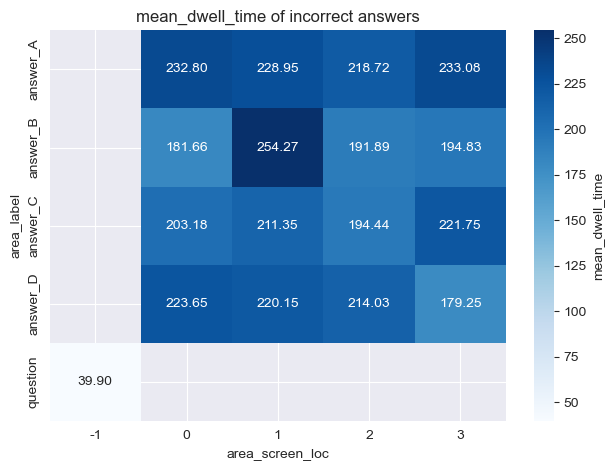

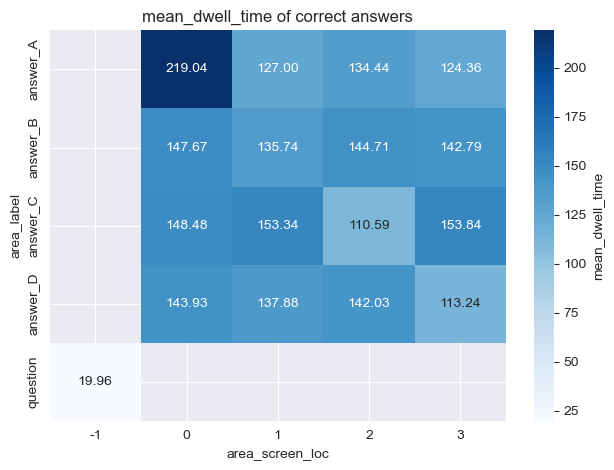

GATHERERS


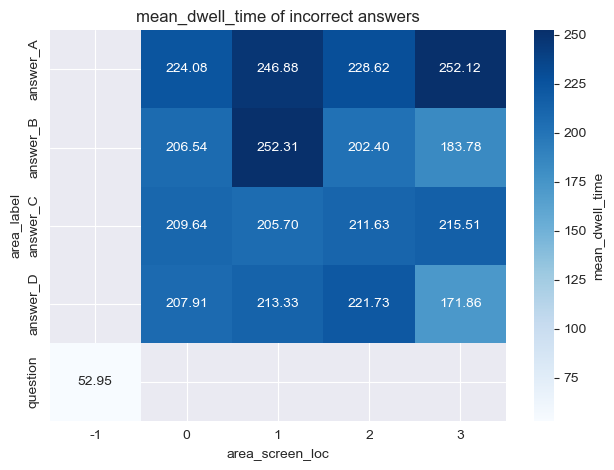

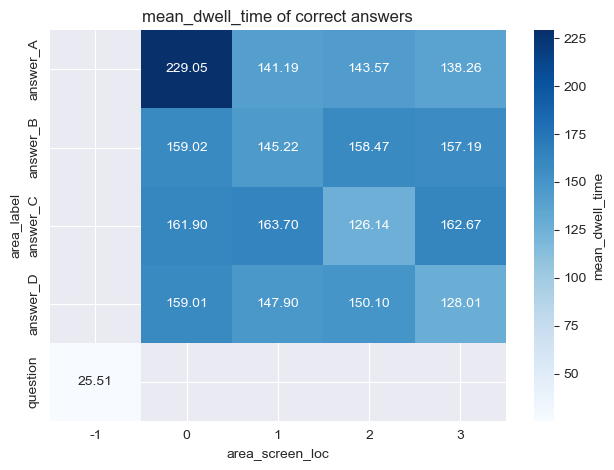

In [31]:
label_vs_loc_mat('mean_dwell_time')
# label_vs_loc_mat('mean_fixations_count')
# label_vs_loc_mat('mean_first_fixation_duration')
# label_vs_loc_mat('skip_rate')
# label_vs_loc_mat('area_dwell_proportion')

### Selected vs not selected

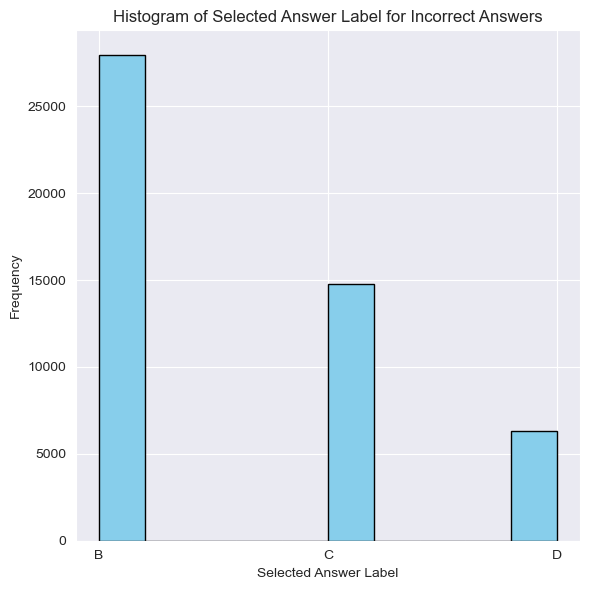

In [32]:
incorrect_answers = df_with_features_h[df_with_features_h['is_correct'] == 0]

plt.figure(figsize=(6, 6))
plt.hist(incorrect_answers['selected_answer_label'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Selected Answer Label for Incorrect Answers')
plt.xlabel('Selected Answer Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

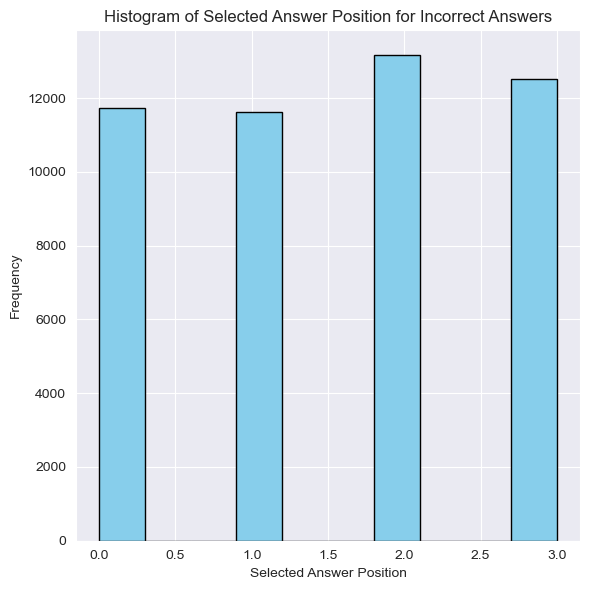

In [33]:
incorrect_answers = df_with_features_h[df_with_features_h['is_correct'] == 0]

plt.figure(figsize=(6, 6))
plt.hist(incorrect_answers['selected_answer_position'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Selected Answer Position for Incorrect Answers')
plt.xlabel('Selected Answer Position')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\deeth\AppData\Local\Temp\ipykernel_22612\4182384254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']


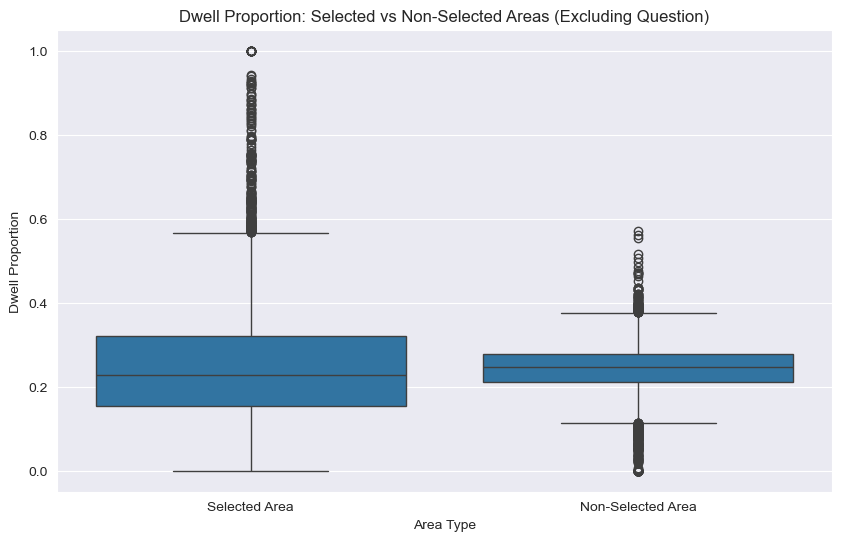

In [34]:
df_filtered = df_with_features_h[df_with_features_h['area_label'].isin(['answer_A', 'answer_B', 'answer_C', 'answer_D'])]
df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']

selected_vs_nonselected = df_filtered.groupby(['TRIAL_INDEX', 'participant_id', 'is_selected_area'])['area_dwell_proportion'].mean().reset_index()
selected_vs_nonselected['area_type'] = selected_vs_nonselected['is_selected_area'].replace({True: 'Selected Area', False: 'Non-Selected Area'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=selected_vs_nonselected,
    x='area_type',
    y='area_dwell_proportion',
    order=['Selected Area', 'Non-Selected Area']
)
plt.title('Dwell Proportion: Selected vs Non-Selected Areas (Excluding Question)')
plt.xlabel('Area Type')
plt.ylabel('Dwell Proportion')
plt.show()


C:\Users\deeth\AppData\Local\Temp\ipykernel_22612\2839663135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']


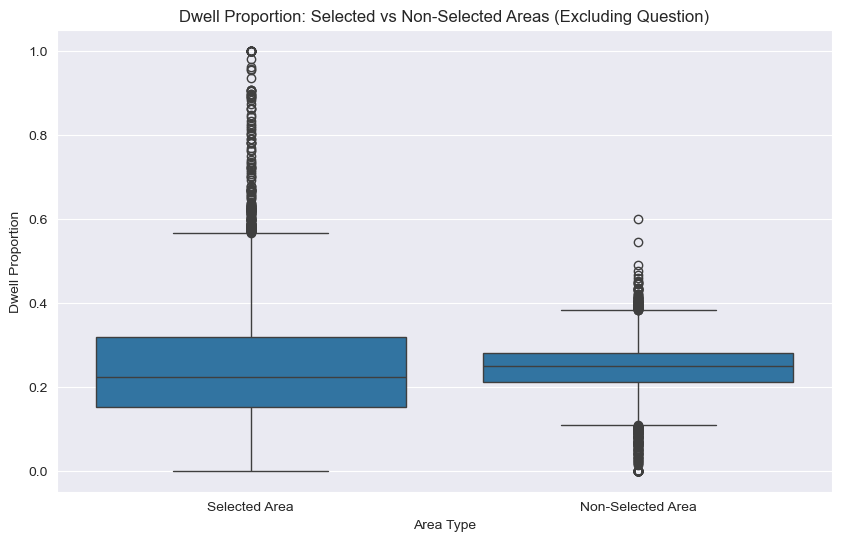

In [35]:
df_filtered = df_with_features_g[df_with_features_g['area_label'].isin(['answer_A', 'answer_B', 'answer_C', 'answer_D'])]
df_filtered['is_selected_area'] = df_filtered['area_label'] == df_filtered['selected_area']

selected_vs_nonselected = df_filtered.groupby(['TRIAL_INDEX', 'participant_id', 'is_selected_area'])['area_dwell_proportion'].mean().reset_index()
selected_vs_nonselected['area_type'] = selected_vs_nonselected['is_selected_area'].replace({True: 'Selected Area', False: 'Non-Selected Area'})

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=selected_vs_nonselected,
    x='area_type',
    y='area_dwell_proportion',
    order=['Selected Area', 'Non-Selected Area']
)
plt.title('Dwell Proportion: Selected vs Non-Selected Areas (Excluding Question)')
plt.xlabel('Area Type')
plt.ylabel('Dwell Proportion')
plt.show()


In [36]:
def wilcoxon_test(df):
    df = df.copy()
    df["is_selected_area"] = df["area_label"] == df["selected_area"]

    paired_data = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(["TRIAL_INDEX", "participant_id"]).apply(
        lambda group: {
            "selected": group.loc[group["is_selected_area"], "area_dwell_proportion"].mean(),
            "non_selected": group.loc[~group["is_selected_area"], "area_dwell_proportion"].mean()
        }
    ).dropna().tolist()

    selected = [pair["selected"] for pair in paired_data]
    non_selected = [pair["non_selected"] for pair in paired_data]

    stat, p_value = wilcoxon(selected, non_selected)
    print('stat, p_value')
    print(stat, p_value)
    differences = np.array(selected) - np.array(non_selected)

    # Check the direction of the differences
    mean_difference = np.mean(differences)
    median_difference = np.median(differences)

    print('differences')
    print(mean_difference, median_difference)


In [37]:
wilcoxon_test(df_with_features_h)
wilcoxon_test(df_with_features_g)

stat, p_value
14499327.5 2.2115702181220467e-237
differences
0.06700492513317233 0.04004613710871699
stat, p_value
15511898.0 9.797851965568629e-188
differences
0.06056058544187989 0.0336665891653104


### Fixation Sequence Visualizations

In [198]:
df_with_features_h['fix_by_label'] = df_with_features_h['fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_label'] = df_with_features_g['fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_h['fix_by_loc'] = df_with_features_h['fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_loc'] = df_with_features_g['fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)


data_rows_h = df_with_features_h[['fix_by_label', 'fix_by_loc', 'selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()
data_rows_g = df_with_features_g[['fix_by_label', 'fix_by_loc', 'selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()


In [199]:
data_rows_h

,index,fix_by_label,fix_by_loc,selected_answer_label,correct_answer_position
0,0,"(question, question, question, question, quest...","(-1, -1, -1, -1, -1, 1, 3, 3, 3, 3, 1, 1, 1, 3...",A,3
1,33,"(out_of_bounds, question, question, answer_A, ...","(out_of_bounds, -1, -1, 1, 1, -1, 1, -1, 1, -1...",A,2
2,73,"(question, answer_A, answer_A, answer_A, answe...","(-1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3, 3, 2, 3,...",A,2
3,114,"(question, question, question, question, answe...","(-1, -1, -1, -1, 3, 1, 2, 3, 2, 1, out_of_boun...",A,2
4,149,"(question, question, question, question, answe...","(-1, -1, -1, -1, 1, 3, 2, out_of_bounds, 2, 3,...",A,2
...,...,...,...,...,...
9678,380126,"(question, out_of_bounds, question, question, ...","(-1, out_of_bounds, -1, -1, -1, 3, -1, -1, -1,...",A,3
9679,380170,"(question, out_of_bounds, question, question, ...","(-1, out_of_bounds, -1, -1, 1, out_of_bounds, ...",A,1
9680,380224,"(question, question, question, question, answe...","(-1, -1, -1, -1, 1, -1, -1, 1, out_of_bounds, ...",C,1
9681,380267,"(answer_A, out_of_bounds, answer_A, answer_A, ...","(1, out_of_bounds, 1, 1, out_of_bounds, 3, 3, ...",A,2


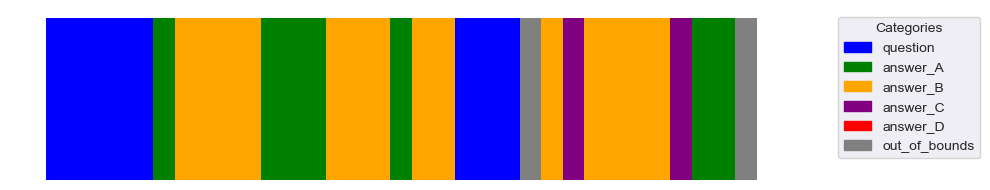

In [58]:
data_row = df_with_features_h.iloc[0]['fix_by_label']

categories = {
    "question": "blue",
    "answer_A": "green",
    "answer_B": "orange",
    "answer_C": "purple",
    "answer_D": "red",
    "out_of_bounds": "gray"
}
colors = [categories[value] for value in data_row]

plt.figure(figsize=(10, 2))
plt.bar(range(len(data_row)), [1] * len(data_row), color=colors, width=1.0, edgecolor='none')
plt.axis('off')

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in categories.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

plt.tight_layout()
plt.show()

In [189]:
categories_label = {
    "question": "blue",
    "answer_A": "green",
    "answer_B": "gold",
    "answer_C": "darkorange",
    "answer_D": "red",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "gray"
}

categories_loc = {
    -1: "blue",
    0: "olive",
    1: "cyan",
    2: "magenta",
    3: "purple",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "gray"
}

legend_mapping_label = {
    "question": "Question",
    "answer_A": "Answer A",
    "answer_B": "Answer B",
    "answer_C": "Answer C",
    "answer_D": "Answer D",
    "out_of_bounds": "Unclear",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

legend_mapping_loc = {
    "out_of_bounds": "Unclear",
    -1: "Question",
    0: "First Q on screen",
    1: "Second Q on screen",
    2: "Third Q on screen",
    3: "Fourth Q on screen",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}


In [202]:
def visualize_stacked_rows_with_two_labels(data_rows, categories, selected_answer_labels, additional_labels, num_rows=100, start_index=0, legend_mapping=None):
    selected_rows = data_rows[start_index:start_index + num_rows]
    selected_labels = selected_answer_labels[start_index:start_index + num_rows]
    additional_labels = additional_labels[start_index:start_index + num_rows]


    max_length = max(len(row) for row in selected_rows) + 2  # +2 to account for the labels

    color_data = []
    for row in selected_rows:
        color_row = [categories.get(value, "gray") for value in row] + ["white"] * (max_length - len(row))
        color_data.append(color_row)

    # Plot the stacked color strips
    plt.figure(figsize=(15, num_rows * 0.3))
    for i, (color_row, label, additional_label) in enumerate(zip(color_data, selected_labels, additional_labels)):
        plt.bar(range(max_length), [1] * max_length, color=color_row, width=1.0, edgecolor='none', bottom=i)
        # Add the additional leading text label
        plt.text(-3.5, i + 0.5, str(additional_label), va='center', ha='right', fontsize=10, color=categories.get(additional_label, "black"))
        # Add the original leading text label
        plt.text(-1.5, i + 0.5, str(label), va='center', ha='right', fontsize=10, color=categories.get(label, "black"))

    plt.axis('off')  # Turn off the axes for a cleaner look

    # Create a legend
    if legend_mapping:
        legend_handles = [
            mpatches.Patch(color=categories.get(original_label, "gray"), label=new_label)
            for original_label, new_label in legend_mapping.items()
            if new_label is not None
        ]
    else:
        legend_handles = [
            mpatches.Patch(color=color, label=str(label)) for label, color in categories.items()
        ]

    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

    plt.tight_layout()
    plt.show()

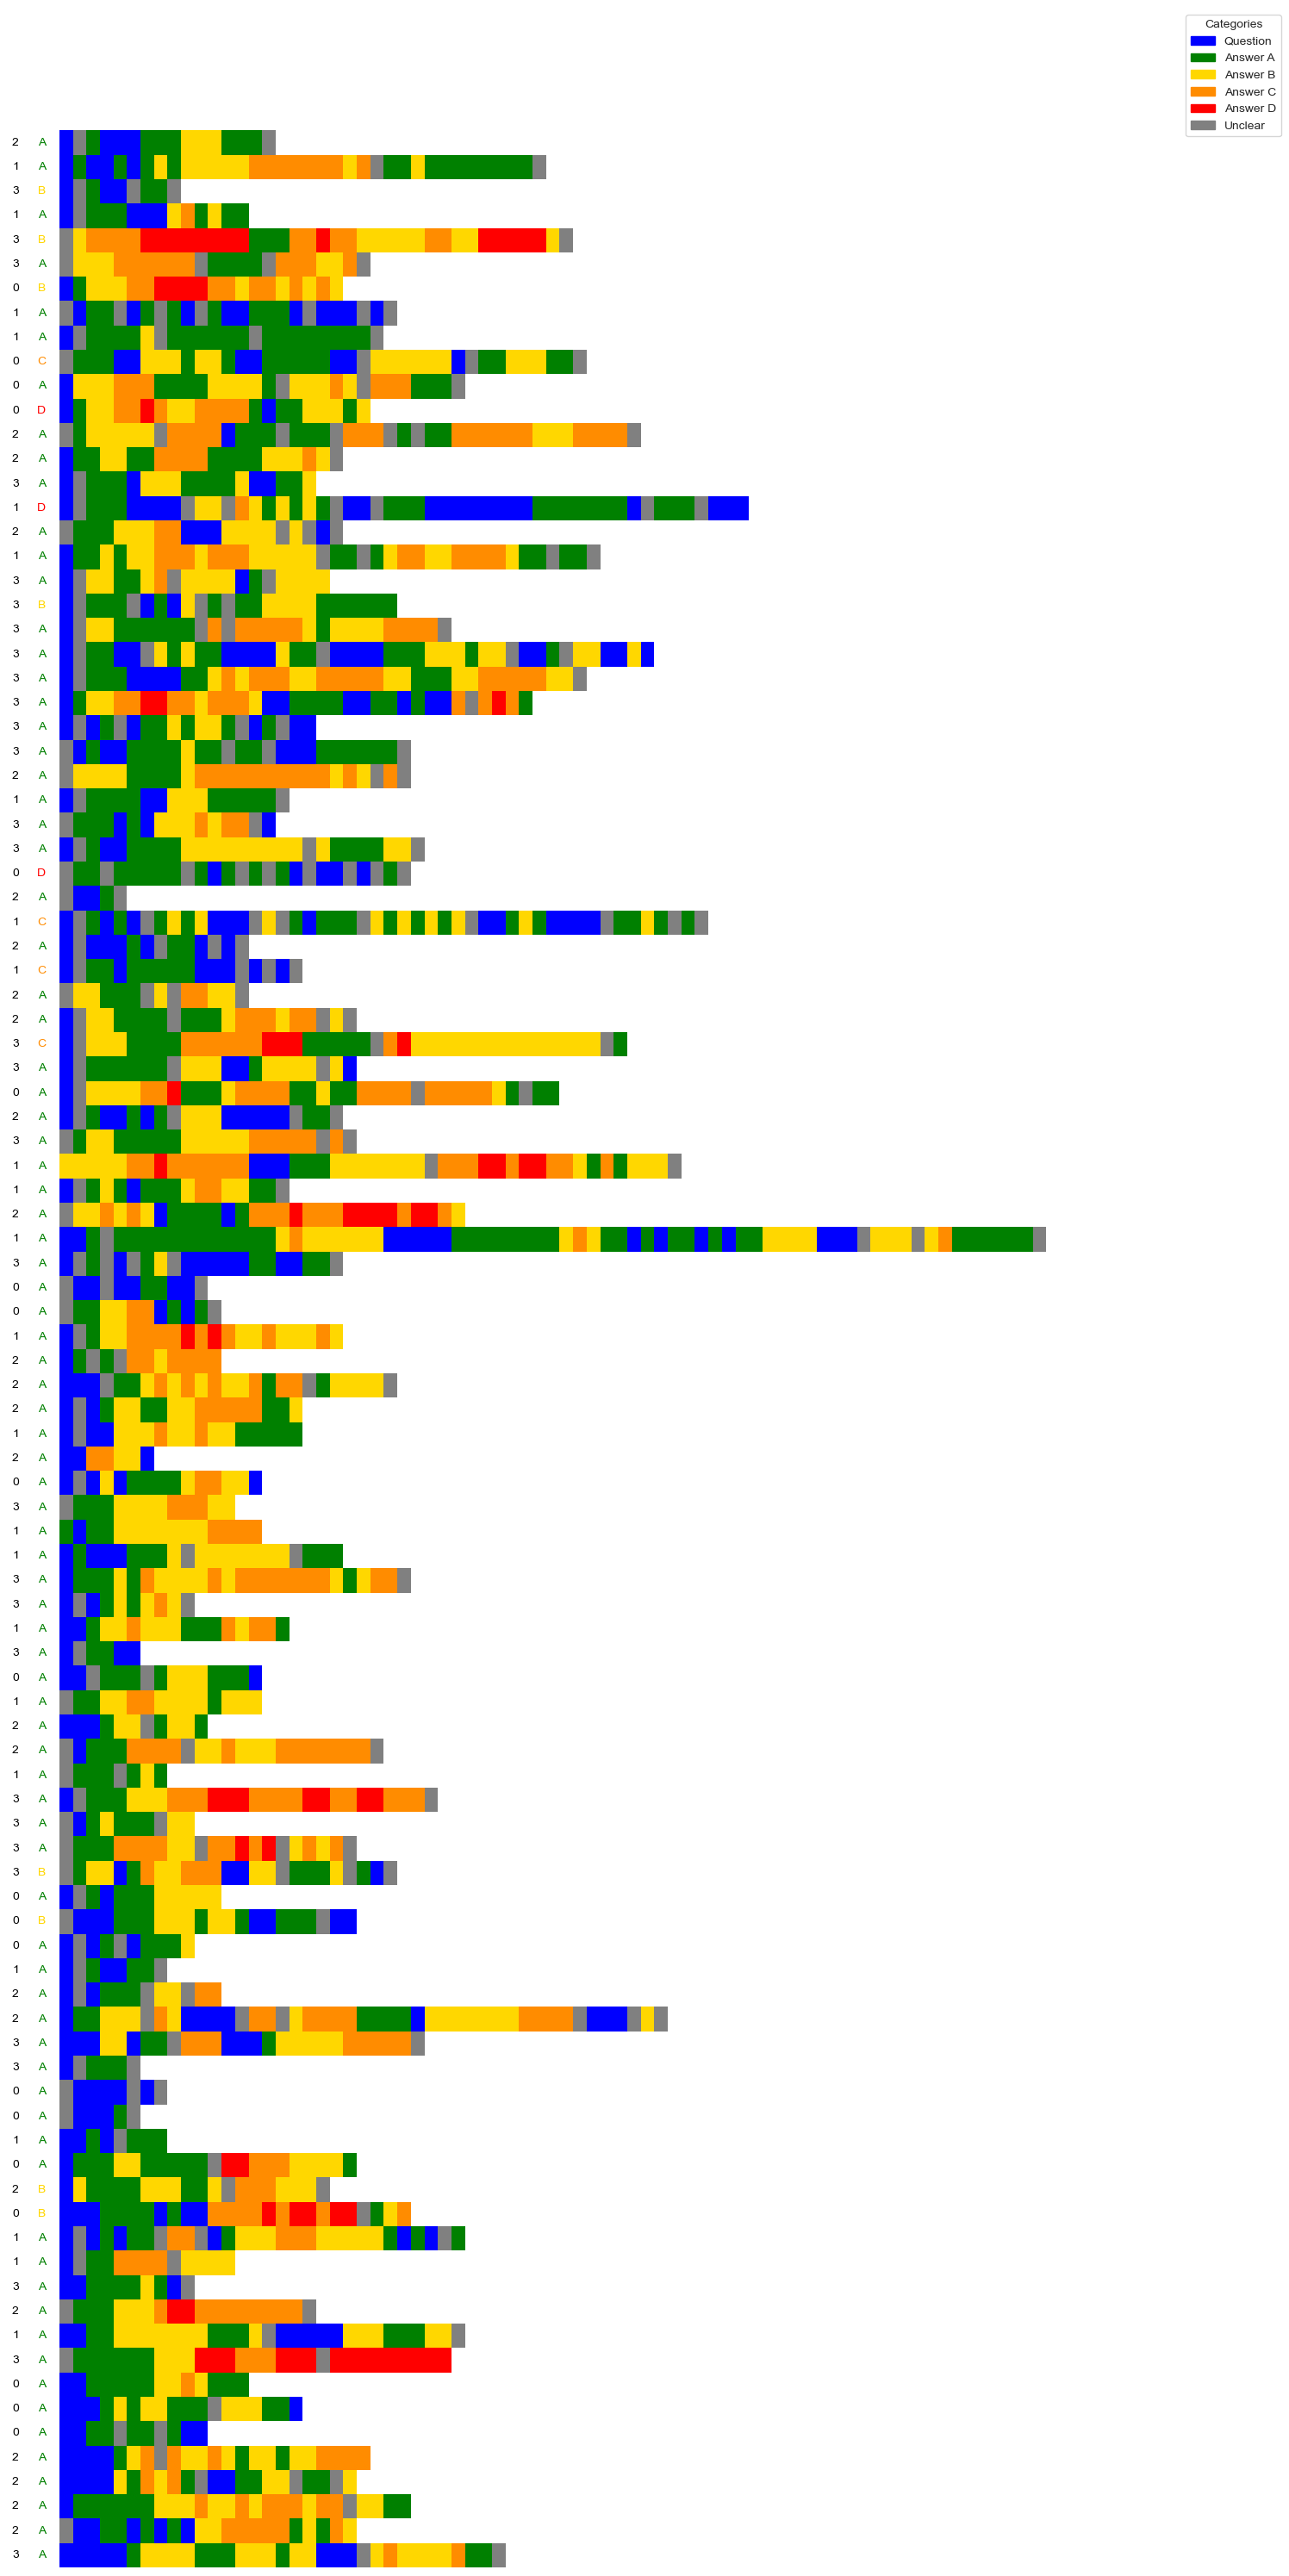

In [203]:
visualize_stacked_rows_with_two_labels(
    data_rows=data_rows_h['fix_by_label'],
    categories=categories_label,
    selected_answer_labels=data_rows_h['selected_answer_label'],
    additional_labels=data_rows_h['correct_answer_position'],
    num_rows=100,
    start_index=0,
    legend_mapping=legend_mapping_label
)

In [209]:
corr_in_zero = data_rows_h[data_rows_h['correct_answer_position'] == 0]

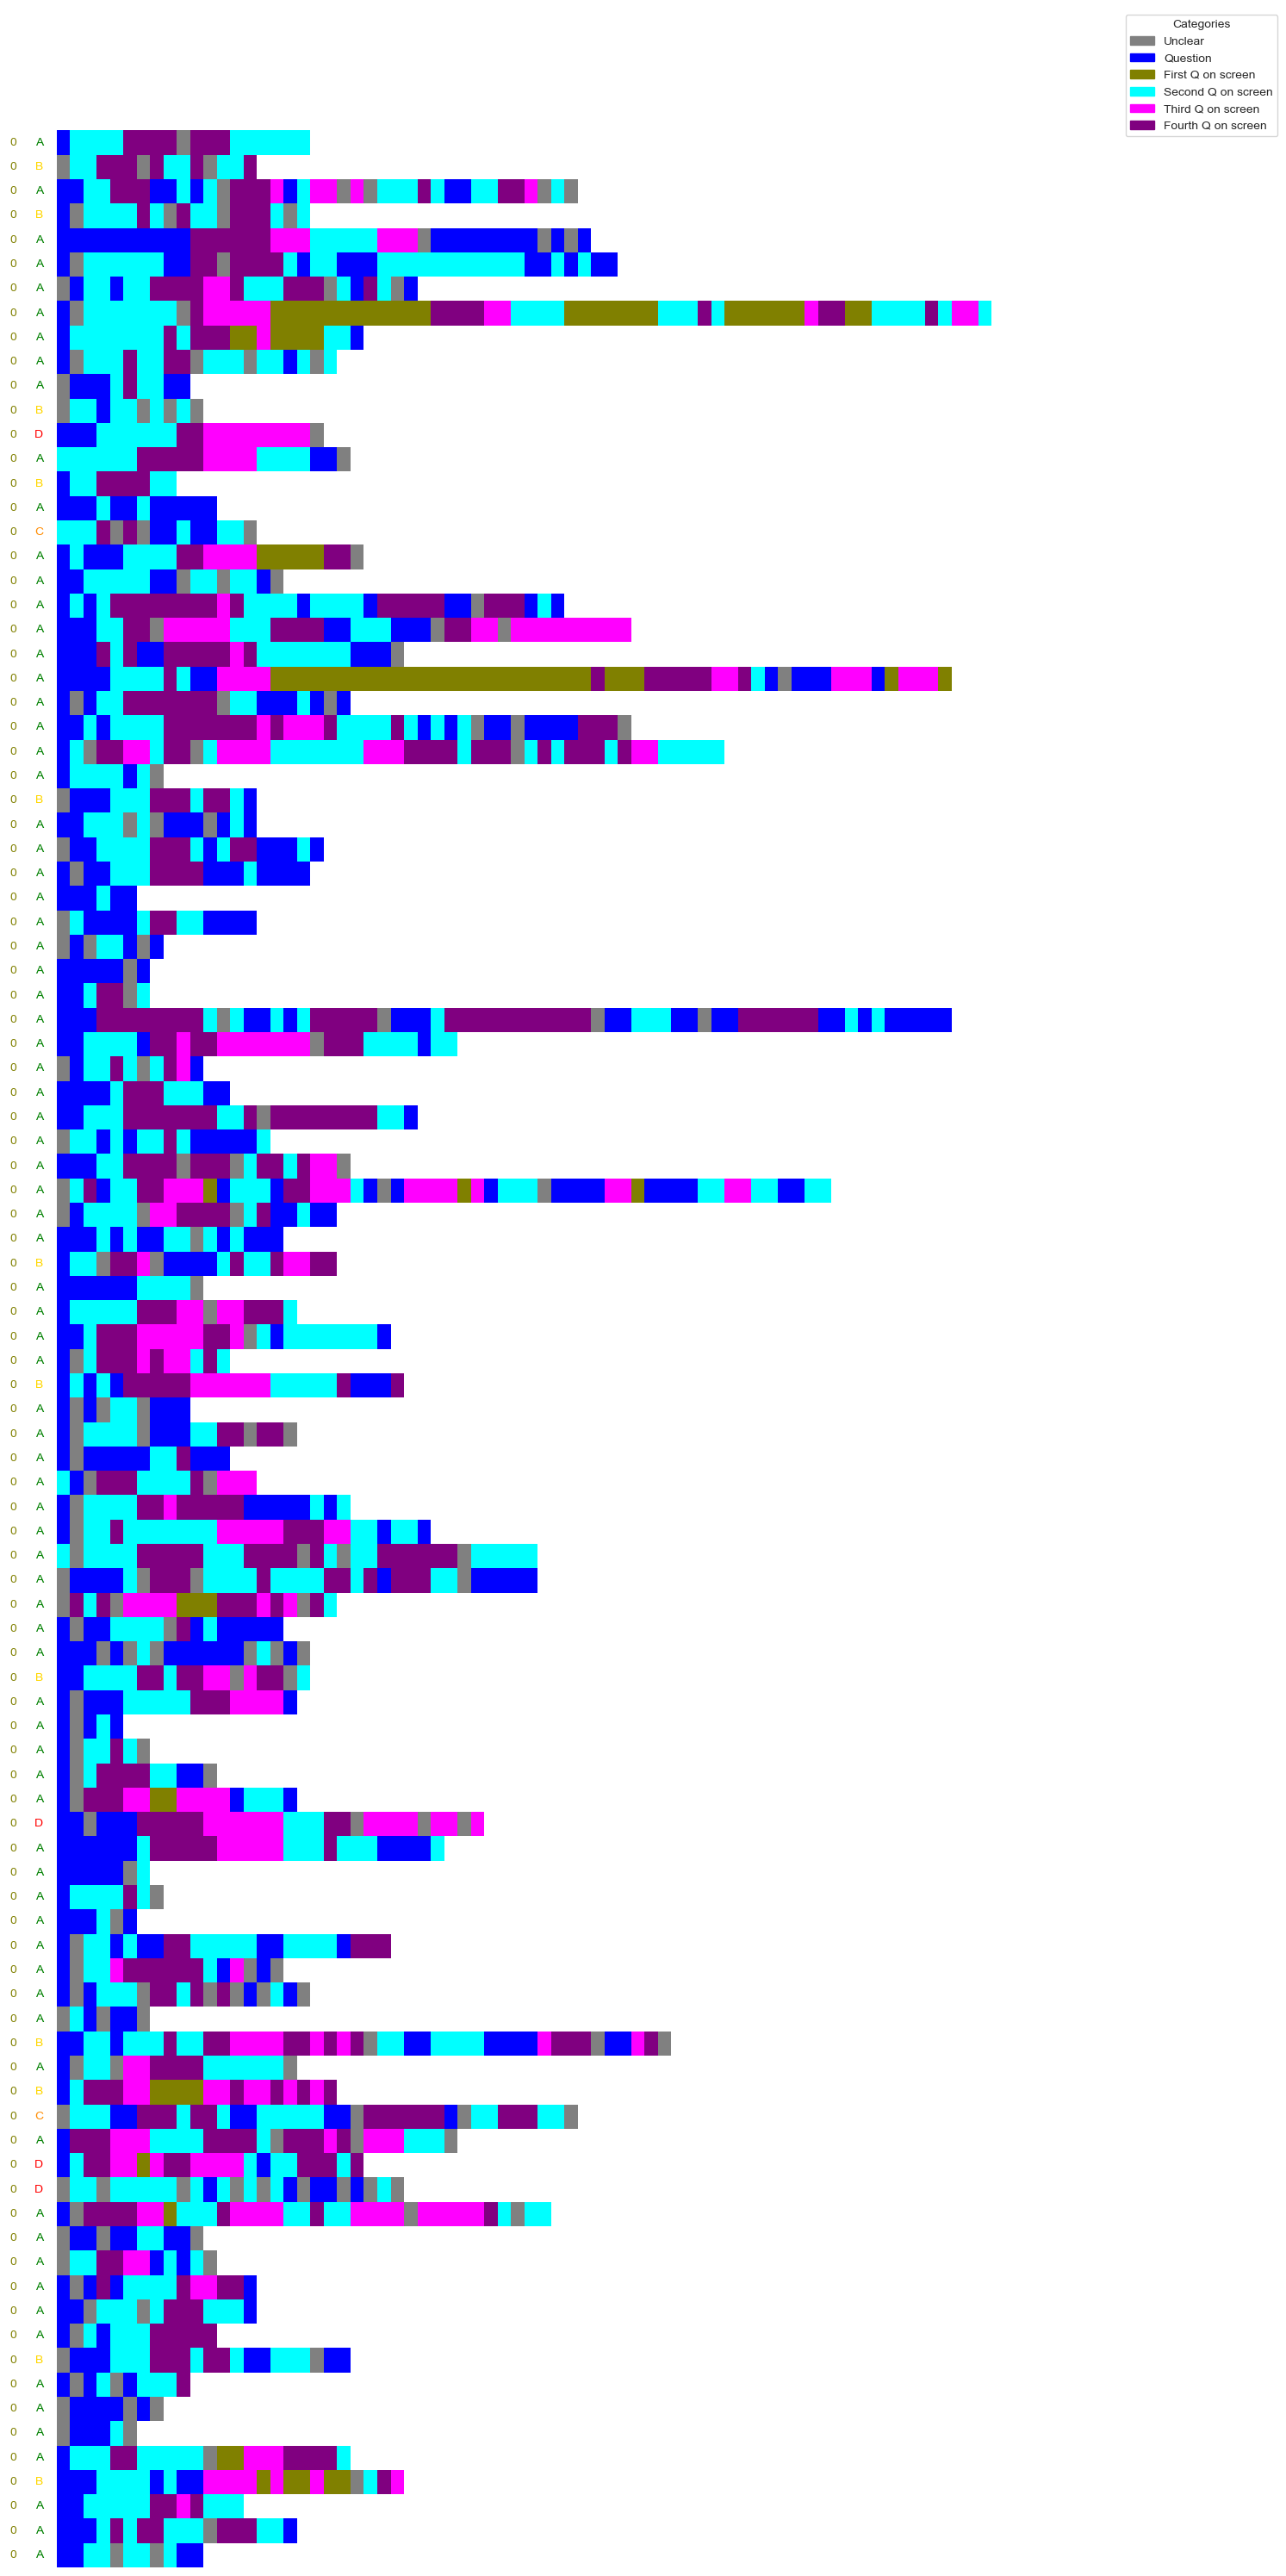

In [210]:
visualize_stacked_rows_with_two_labels(
    data_rows=corr_in_zero['fix_by_loc'],
    categories=categories_loc,
    selected_answer_labels=corr_in_zero['selected_answer_label'],
    additional_labels=corr_in_zero['correct_answer_position'],
    num_rows=100,
    start_index=0,
    legend_mapping=legend_mapping_loc
)


# Some sanity checks

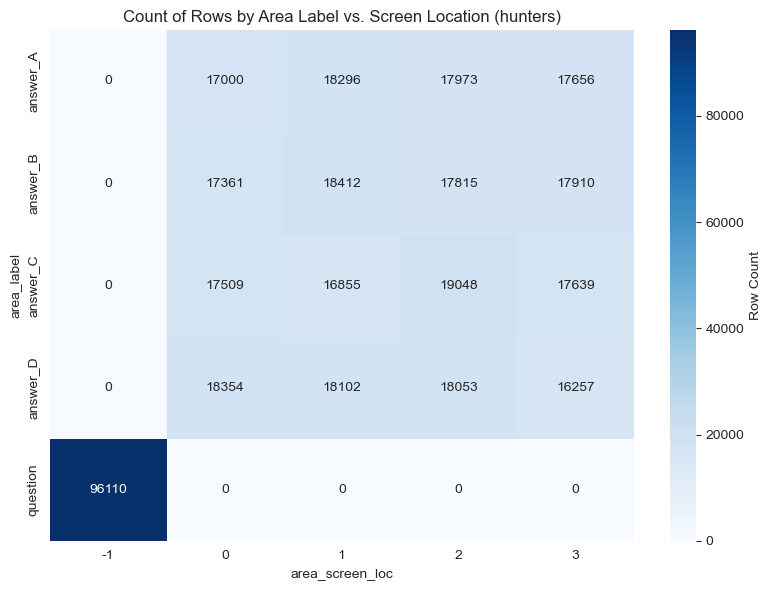

In [38]:
count_matrix = (df_with_features_h
    .groupby(['area_label', 'area_screen_loc'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Row Count'}
)
plt.title("Count of Rows by Area Label vs. Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

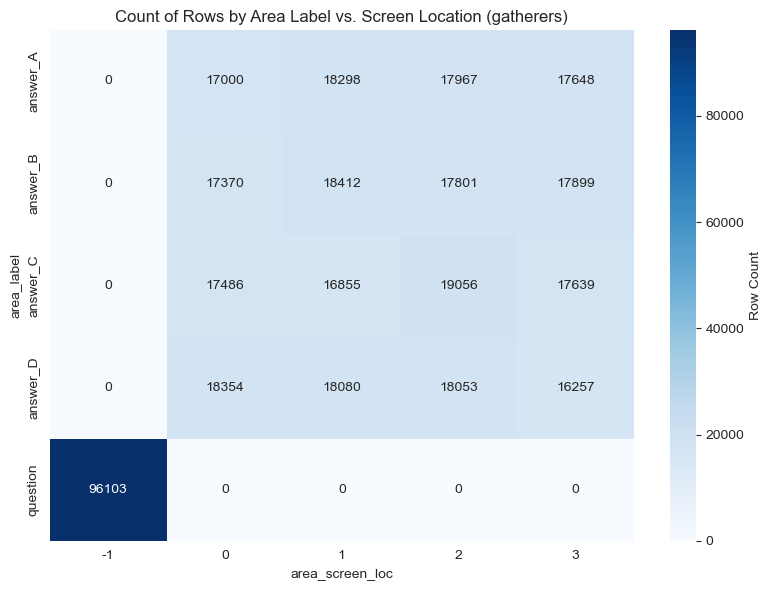

In [39]:
count_matrix = (df_with_features_g
    .groupby(['area_label', 'area_screen_loc'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Row Count'}
)
plt.title("Count of Rows by Area Label vs. Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

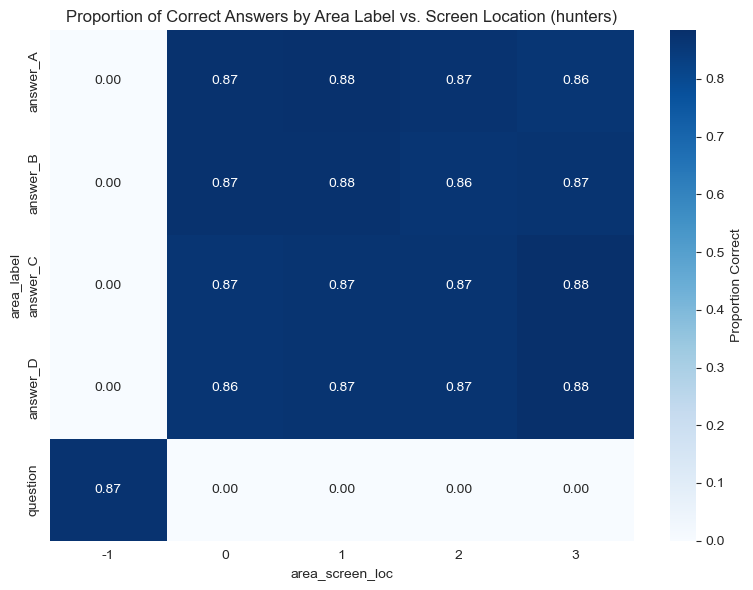

In [40]:
prop_matrix = (
    df_with_features_h
    .groupby(['area_label', 'area_screen_loc'])['is_correct']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    prop_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Correct'}
)
plt.title("Proportion of Correct Answers by Area Label vs. Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

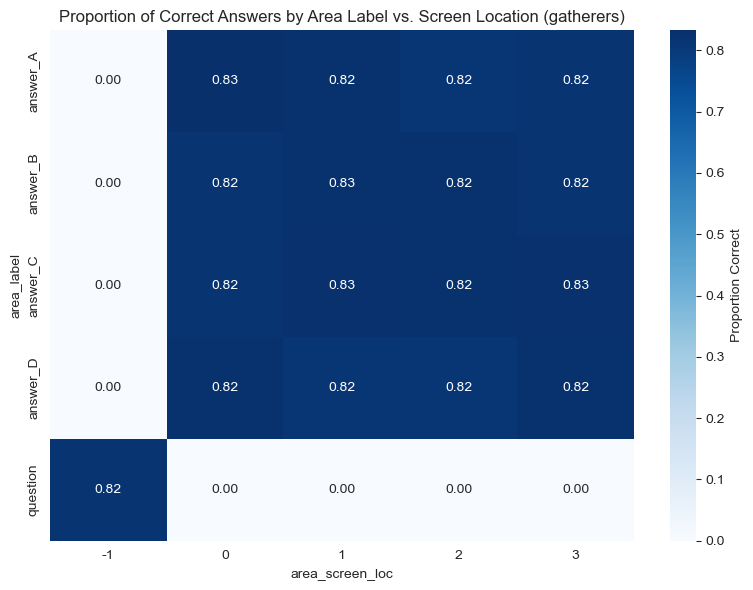

In [41]:
prop_matrix = (
    df_with_features_g
    .groupby(['area_label', 'area_screen_loc'])['is_correct']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    prop_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Correct'}
)
plt.title("Proportion of Correct Answers by Area Label vs. Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("area_label")
plt.tight_layout()
plt.show()

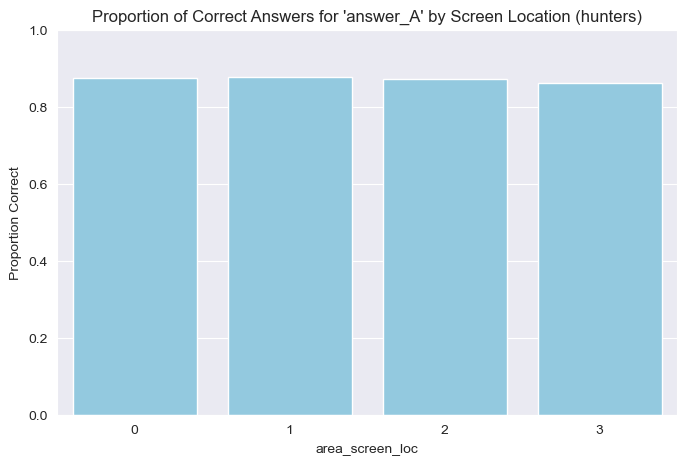

In [42]:
df_answer_A = df_with_features_h[df_with_features_h['area_label'] == 'answer_A']

prop_correct = (
    df_answer_A
    .groupby('area_screen_loc')['is_correct']
    .mean()
    .reset_index(name='prop_correct')
)

plt.figure(figsize=(8, 5))
sns.barplot(data=prop_correct, x='area_screen_loc', y='prop_correct', color='skyblue')
plt.ylim(0, 1)
plt.title("Proportion of Correct Answers for 'answer_A' by Screen Location (hunters)")
plt.xlabel("area_screen_loc")
plt.ylabel("Proportion Correct")
plt.show()

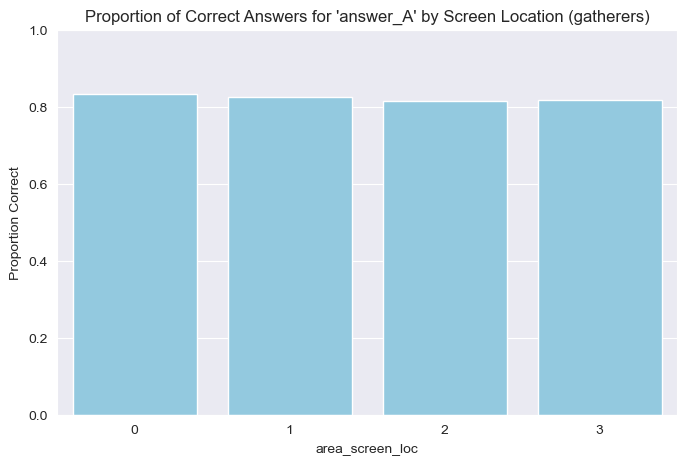

In [43]:
df_answer_A = df_with_features_g[df_with_features_g['area_label'] == 'answer_A']

prop_correct = (
    df_answer_A
    .groupby('area_screen_loc')['is_correct']
    .mean()
    .reset_index(name='prop_correct')
)

plt.figure(figsize=(8, 5))
sns.barplot(data=prop_correct, x='area_screen_loc', y='prop_correct', color='skyblue')
plt.ylim(0, 1)
plt.title("Proportion of Correct Answers for 'answer_A' by Screen Location (gatherers)")
plt.xlabel("area_screen_loc")
plt.ylabel("Proportion Correct")
plt.show()

In [44]:
order_correct_df = (
    df_with_features_h.groupby('answers_order')['is_correct']
      .mean()
      .reset_index(name='prop_correct')
)

order_correct_df = order_correct_df.sort_values('prop_correct', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=order_correct_df,
    x='answers_order',
    y='prop_correct',
    order=order_correct_df['answers_order'],
    color='skyblue'
)

plt.ylim(0, 1)
plt.title("Proportion of Correct Answers by Answers Order (Sorted) (hunters)")
plt.xlabel("Answers Order")
plt.ylabel("Proportion Correct")

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


TypeError: unhashable type: 'list'

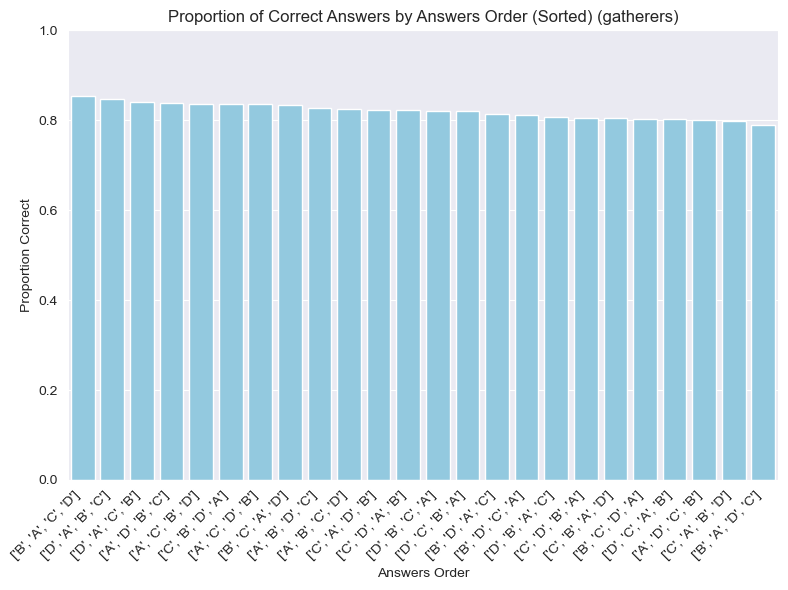

In [39]:
order_correct_df = (
    df_with_features_g.groupby('answers_order')['is_correct']
      .mean()
      .reset_index(name='prop_correct')
)

order_correct_df = order_correct_df.sort_values('prop_correct', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=order_correct_df,
    x='answers_order',
    y='prop_correct',
    order=order_correct_df['answers_order'],
    color='skyblue'
)

plt.ylim(0, 1)
plt.title("Proportion of Correct Answers by Answers Order (Sorted) (gatherers)")
plt.xlabel("Answers Order")
plt.ylabel("Proportion Correct")

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [40]:
df_h = df_with_features_h[['participant_id', 'TRIAL_INDEX', 'answers_order', 'is_correct']].drop_duplicates()
df_h

,participant_id,TRIAL_INDEX,answers_order,is_correct
0,l42_2070,4,"['B', 'C', 'D', 'A']",1
33,l42_2070,5,"['B', 'C', 'A', 'D']",1
73,l42_2070,6,"['C', 'D', 'A', 'B']",1
114,l42_2070,7,"['B', 'D', 'A', 'C']",1
149,l42_2070,8,"['D', 'B', 'A', 'C']",1
...,...,...,...,...
380126,l10_39,55,"['B', 'C', 'D', 'A']",1
380170,l10_39,56,"['D', 'A', 'B', 'C']",1
380224,l10_39,57,"['D', 'A', 'C', 'B']",0
380267,l10_39,58,"['B', 'C', 'A', 'D']",1


In [41]:
import statsmodels.formula.api as smf

df_h['is_correct'] = df_h['is_correct'].astype(int)

df_h['answers_order'] = df_h['answers_order'].astype('category')
df_h['participant_id'] = df_h['participant_id'].astype('category')
df_h['TRIAL_INDEX'] = df_h['TRIAL_INDEX'].astype('category')

model = smf.mixedlm(
    "is_correct ~ C(answers_order)",
    data=df_h,
    groups=df_h["participant_id"],
    re_formula="~1"
)

result = model.fit()
print(result.summary())

                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          is_correct
No. Observations:          9719             Method:                      REML      
No. Groups:                180              Scale:                       0.1104    
Min. group size:           53               Log-Likelihood:              -3232.6356
Max. group size:           54               Converged:                   Yes       
Mean group size:           54.0                                                    
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.880    0.017 52.779 0.000  0.847  0.912
C(answers_order)[T.['A', 'B', 'D', 'C']]  0.007    0.023  0.286 0.775 -0.039  0.052
C(answers_order

C:\Users\deeth\miniconda3\envs\default_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
